# k-Nearest Neighbors

In [ ]:
# Function that counts votes

from typing import List
from collections import Counter

def raw_majority_vote(labels:List[str]) -> str:
    votes = Counter(labels)
    winner,_ = votes.most_common(1)[0]
    return winner

assert raw_majority_vote(['a','b','c','b']) == 'b'

"""
 In case we have equal votes we can do:
- Pick one of the winners at random.
- Weight the votes by distance and pick the weightd winner.
-Reduce k until we find a unique winner
"""
def majority_vote(labels:List[str])->str:
    """ Assumes that labels are ordered from nearest to farthest """
    vote_counts = Counter(labels)
    winner,winner_count = vote_counts.most_common(1)[0]
    num_winners  = len([count 
                        for count in vote_counts.values()
                        if count == winner_count])

    if num_winners == 1:
        return winner

    else:
        return majority_vote(labels[:-1])


assert majority_vote(['a','b','c','b','a']) == 'b' 

#### Below code is from Ch-4

In [17]:
from typing import List
import math

Vector = List[float]

def dot(v:Vector,w:Vector)-> Vector:
    assert len(v) == len(w)
    return sum(v_i*w_i for v_i, w_i in zip(v,w))

# Vector's sum of squares
def sum_of_squares(v:Vector)->float:
    return dot(v,v)

def subtract(v:Vector,w:Vector)->Vector:
    return [v_i - w_i for v_i,w_i in zip(v,w)]

# Distance between two vectors
def squared_distance(v:Vector, w:Vector) -> float:
    return sum_of_squares(subtract(v,w))

def distance(v:Vector, w:Vector) -> float:
    return math.sqrt(squared_distance(v,w))

#### Create a classifier

In [19]:
from typing import NamedTuple,List

Vector = List[float]

class LabeledPoint(NamedTuple):
    point: Vector
    label: str

def knn_classify(k:int,
                 labeled_points:List[LabeledPoint],
                 new_point: Vector
                 )->str:
    
    # order the labeled points from nearest to farthest
    by_distance = sorted(labeled_points,key=lambda lp:distance(lp.point,new_point))

    # find the labels for the k closest 
    k_nearest_labels  = [lp.label for lp in by_distance[:k]]


    # and let them vote 
    return majority_vote(k_nearest_labels)

## The Iris Dataset

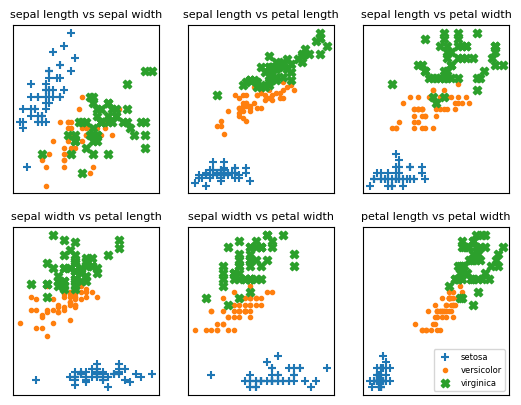

In [13]:
import requests
data = requests.get("https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data")

with open('iris.dat','w') as f:
    f.write(data.text)

# data is separated as:
# sepal_length, sepal_width, petal_length, petal_width, class

from typing import Dict, List
import csv
from collections import defaultdict

def parse_iris_row(row: List[str]) -> LabeledPoint:
    measurements = [float(value) for value in row[:-1]]
    # class is e.g "Iris-Virginica", we just want "virginica"
    label = row[-1].split('-')[-1]
    return LabeledPoint(measurements,label)


with open('iris.data') as f:
    reader = csv.reader(f)
    iris_data = [parse_iris_row(row) for row in reader]

# we will also group just the points by species/label so we can plot them
points_by_species: Dict[str, List[Vector]] = defaultdict(list)
for iris in iris_data:
    points_by_species[iris.label].append(iris.point)


''' Plot the measurements to see how they vary by species '''

from matplotlib import pyplot as plt
metrics = ['sepal length','sepal width','petal length','petal width']
pairs = [(i,j) for i in range(4) for j in range(4) if i<j]
marks  = ['+','.','X']    # we have 3 classes, so 3 markers

fig, ax = plt.subplots(2,3)
for row in range(2):
    for col in range(3):
        i,j = pairs[3*row+col]
        ax[row][col].set_title(f"{metrics[i]} vs {metrics[j]}",fontsize=8)
        ax[row][col].set_xticks([])
        ax[row][col].set_yticks([])

        for mark,(species,points) in zip(marks,points_by_species.items()):
            xs = [point[i] for point in points]
            ys = [point[j]for point in points]
            ax[row][col].scatter(xs,ys,marker=mark, label=species)

ax[-1][-1].legend(loc='lower right',prop={'size':6})
plt.show()


In [22]:
""" Let's split the data into a test set and training set """

from typing import TypeVar
import random

X = TypeVar('X')
def split_data(data:List[X],prob:int)-> List[X]:
    data = data[:]
    random.shuffle(data)
    cut = int(len(data)*prob)
    return data[:cut], data[cut:]

random.seed(12)
iris_train,iris_test = split_data(iris_data,0.70)
assert len(iris_train) == 0.7*150
assert len(iris_test) == 0.3*150

"""
Training set will be the neighbours and for Knn we have to choose the value of k, here we take k=5
"""

from collections import Counter

def knn_classify(k:int,
                 labeled_points:List[LabeledPoint],
                 new_point: Vector
                 )->str:
    
    # order the labeled points from nearest to farthest
    by_distance = sorted(labeled_points, key=lambda lp: distance(lp.point, new_point))

    # find the labels for the k closest 
    k_nearest_labels = [lp.label for lp in by_distance[:k]]

    # vote: return the most common label
    vote_counts = Counter(k_nearest_labels)
    return vote_counts.most_common(1)[0][0]  # returns a single string


from typing import Tuple

# track how many times we see(predicted, actual)
confusion_matrix: Dict[Tuple[str,str], int] = defaultdict(int)
num_correct = 0

for iris in iris_test:
    predicted = knn_classify(5,iris_train,iris.point)
    actual = iris.label

    if predicted == actual:
        num_correct += 1 

    confusion_matrix[(predicted,actual)] += 1

pct_correct = num_correct/len(iris_test)
print(pct_correct,confusion_matrix)

0.9777777777777777 defaultdict(<class 'int'>, {('setosa', 'setosa'): 13, ('versicolor', 'versicolor'): 15, ('virginica', 'virginica'): 16, ('virginica', 'versicolor'): 1})


## The Curse of Dimensionality

 k-nearest neighbours algorithm runs into trouble in higher dimensions because of curse of dimensionality.
 Points in high dimensional spaces tend not to be close to one another at all.

In [ ]:
# Generating random points

def random_point(dim:int)->Vector:
    return[random.random() for _ in range(dim)]

def random_distances(dim:int,num_pairs:int) -> List[float]:
    return [distance(random_point(dim),random_point(dim))
            for _ in range(num_pairs)]

""" For every dimension from 1 to 100, we'll compare 10,000 distances and use them to compute the average distance between points and the minimum distance between points in each dimension """

import tqdm
dimensions = range(1,101)

avg_distances = []
min_distances = []

random.seed(0)
for dim in tqdm.tqdm(dimensions,desc="Curse of Dimensionality"):
    distances = random_distances(dim,10000)
    avg_distances.append(sum(distances)/10000)
    min_distances.append(min(distances))
    

Curse of Dimensionality: 100%|██████████| 100/100 [00:10<00:00,  9.98it/s]


After plotting above data we can say: <br>

As the number of dimensions increases, the average distance between point increases.

In [ ]:
min_avg_ratio = [min_dist/avg_dist
                 for min_dist,avg_dist in zip(min_distances,avg_distances)]

More dimensions = more space = points spread out = closeness loses meaning.